# Clustering del case_2 : KBLEE

In [23]:
# Importación de Librerias
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import seaborn as sns
import plotly.graph_objects as go

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.cluster import KMeans, BisectingKMeans, DBSCAN, HDBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import adjusted_rand_score

from kneed import KneeLocator

from imblearn.over_sampling import SMOTENC

In [24]:
# Modifico el código para que no se me trunquen los resultados con Jupiter Notebook
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 1000)

In [25]:
# Cargo el dataset
#data = pd.read_csv(r'C:\Users\nfersob\OneDrive - BAHIA SOFTWARE SL\TFM\Código\Preprocesado\dt_unificado1_2.csv', delimiter=';')
data = pd.read_csv(r'/Users/nicofernandez/TFM/Bahía/Bahía/TFM/TFM sí/Código/Preprocesado/dt_unificado1_2.csv', delimiter=';')

In [26]:
# Guardo la variable de los casos
case_1 = data['case_1']
case_2 = data['case_2']
id_paciente = data['id_paciente']
exitus = data['exitus']

# Modifico la variable case para que yes = 1 y no = 0
case_1 = case_1.map({'yes':1, 'no':0})
case_2 = case_2.map({'yes':1, 'no':0})

# Separo las características en variables y respuesta
variables_eliminar = ['case_1', 'case_2', 'exitus', 'id_paciente']
variables = data.drop(columns=variables_eliminar)
respuesta = case_2
print(respuesta.value_counts())

# Hold-Out con estratificación para mantener las proporciones
X_train, X_test, y_train, y_test = train_test_split(variables, respuesta, test_size=0.2, stratify=respuesta, random_state=789)
# X_train son los datos del dataset 'variables' que se usan para entrenamiento (80%)
# y_train son los datos del dataset 'respuesta' que se usan para entrenamiento (80%)
# X_test son los datos del dataset 'variables' que se usan para el test (20%)
# y_test son los datos del dataset 'respuesta' que se usan para el test (20%)

# Compruebo las proporciones para ver si la división de los conjuntos es correcta
print(f'\nProporción de datos originales: {respuesta.value_counts(normalize=True)}')
print(f'\nProporción de datos del entrenamiento: {y_train.value_counts(normalize=True)}')
print(f'\nProporción de datos del test: {y_test.value_counts(normalize=True)}')

case_2
0    1448
1     506
Name: count, dtype: int64

Proporción de datos originales: case_2
0    0.741044
1    0.258956
Name: proportion, dtype: float64

Proporción de datos del entrenamiento: case_2
0    0.740883
1    0.259117
Name: proportion, dtype: float64

Proporción de datos del test: case_2
0    0.741688
1    0.258312
Name: proportion, dtype: float64


In [27]:
# Separación en variables numéricas y variables categóricas
numeric_features = ['elixhauser_score_ahrq_vanwalraven','elixhauser_score_ahrq_sid29','elixhauser_score_ahrq_sid30','elixhauser_score_quan_vanwalraven','elixhauser_score_quan_sid29',
                    'elixhauser_score_quan_sid30','sofa','qsofa','saps','sapsii','sapsii_prob','apsiii','apsiii_prob','patient_age','hours_between_admission_and_first_icu',
                    'hours_in_icu_in_previous_admissions','hours_in_icu_in_previous_admissions_and_the_current_one','number_of_colonizations_in_the_current_admission']

categorical_features = ['patient_gender', 'previous_colonization_with_enterobacterales_cre','previous_colonization_with_pseudomonas_aeruginosa','previous_colonization_with_acinetobacter_baumannii',
                        'previous_colonization_with_sarm','previous_colonization_with_stenotrophomonas_maltophilia','previous_colonization_with_erv','previous_exposure_to_third_generation_cephalosporins',
                        'previous_exposure_to_carbapenems','previous_exposure_to_fluorquinolones','previous_exposure_to_aminoglycosides','previous_exposure_to_b_lactam','previous_exposure_to_antifungal_agents',
                        'previous_exposure_to_glycopeptides','mechanical_ventilation_in_previous_admissions','mechanical_ventilation_in_the_current_admission','organ_transplant_in_previous_admissions',
                        'organ_transplant_in_the_current_admission','hematopoietic_transplant_in_previous_admissions','hematopoietic_transplant_in_the_current_admission','catheter_in_previous_admissions',
                        'catheter_in_the_current_admission','readmission','admission_type', 'admission_location']

X_train_categorica = X_train[categorical_features]
X_train_numerica = X_train[numeric_features]

X_test_categorica = X_test[categorical_features]
X_test_numerica = X_test[numeric_features]

# Aplico One-Hot Encoding solo a las variables categóricas
encoder = OneHotEncoder(drop = 'if_binary', sparse_output = False) 
# drop ='if_binary' se pone porque las catergorias yes/no solo aparezca un valor (si no es yes, es no)
# sparse_output = False no se si hace falta
X_train_categorical_encoded = encoder.fit_transform(X_train_categorica)
X_test_categorical_encoded = encoder.fit_transform(X_test_categorica)

# Convierto los array en dataframes
X_train_categorical_encoded_df = pd.DataFrame(X_train_categorical_encoded, columns=encoder.get_feature_names_out(X_train_categorica.columns))
X_test_categorical_encoded_df = pd.DataFrame(X_test_categorical_encoded, columns=encoder.get_feature_names_out(X_test_categorica.columns))

# Reseteo los índices para evitar problemas en la concatenación
X_train_categorical_encoded_df.reset_index(drop = True, inplace=True)
X_test_categorical_encoded_df.reset_index(drop=True, inplace=True)
X_train_numerica.reset_index(drop=True, inplace=True)
X_test_numerica.reset_index(drop=True, inplace=True)

# Concateno el DataFrame de variables numericas y categóricas transformadas
X_train = pd.concat([X_train_numerica, X_train_categorical_encoded_df], axis=1)
X_test = pd.concat([X_test_numerica, X_test_categorical_encoded_df], axis=1)

Proporción de datos originales:  case_2
0    0.741044
1    0.258956
Name: proportion, dtype: float64

Proporción de datos de entrenamiento:  case_2
0    0.5
1    0.5
Name: proportion, dtype: float64

Proporción de datos del test:  case_2
0    0.741688
1    0.258312
Name: proportion, dtype: float64


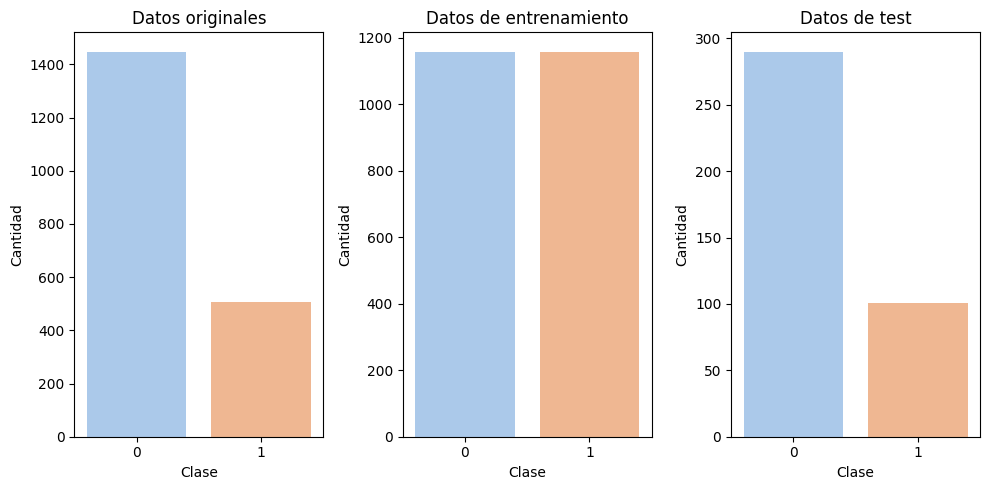

In [28]:
# Determino cuales son las columnas con variables categóricas
categorical_encoded_columns = encoder.get_feature_names_out(X_train_categorica.columns)
# Saco los indices para indicarlo en SMOTENC
categorical_indices = []
for col in categorical_encoded_columns:
    categorical_indices.append(X_train.columns.get_loc(col))

# Aplico SMOTENC
smote_nc = SMOTENC(categorical_features=categorical_indices, random_state=789)
X_train, y_train = smote_nc.fit_resample(X_train, y_train)

# Proporción de cómo quedan los datos depués del balanceo en el entrenamiento
print('Proporción de datos originales: ', respuesta.value_counts(normalize=True))
print('\nProporción de datos de entrenamiento: ', y_train.value_counts(normalize=True))
print('\nProporción de datos del test: ', y_test.value_counts(normalize=True))

# Representación gráfica de antes y después del balanceo de los datos
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10,5))

# Para respuesta
sns.countplot(x=respuesta, hue=respuesta, ax=axes[0], palette='pastel', legend=False)
axes[0].set_title('Datos originales')
axes[0].set_xlabel('Clase')
axes[0].set_ylabel('Cantidad')

# Para los datos de entrenamiento
sns.countplot(x=y_train, hue=y_train, legend=False, ax=axes[1], palette='pastel')
axes[1].set_title('Datos de entrenamiento')
axes[1].set_xlabel('Clase')
axes[1].set_ylabel('Cantidad')

# Para los datos de test
sns.countplot(x=y_test, hue=y_test, legend=False, ax=axes[2], palette='pastel')
axes[2].set_title('Datos de test')
axes[2].set_xlabel('Clase')
axes[2].set_ylabel('Cantidad')

plt.tight_layout()
plt.show()

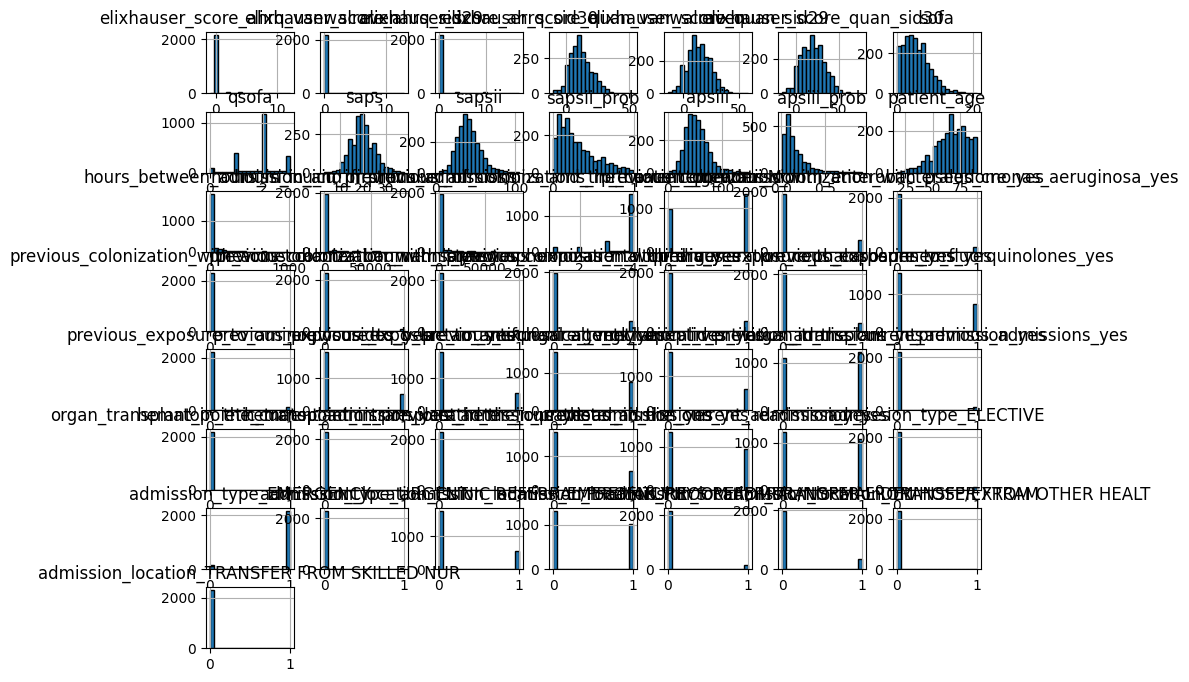

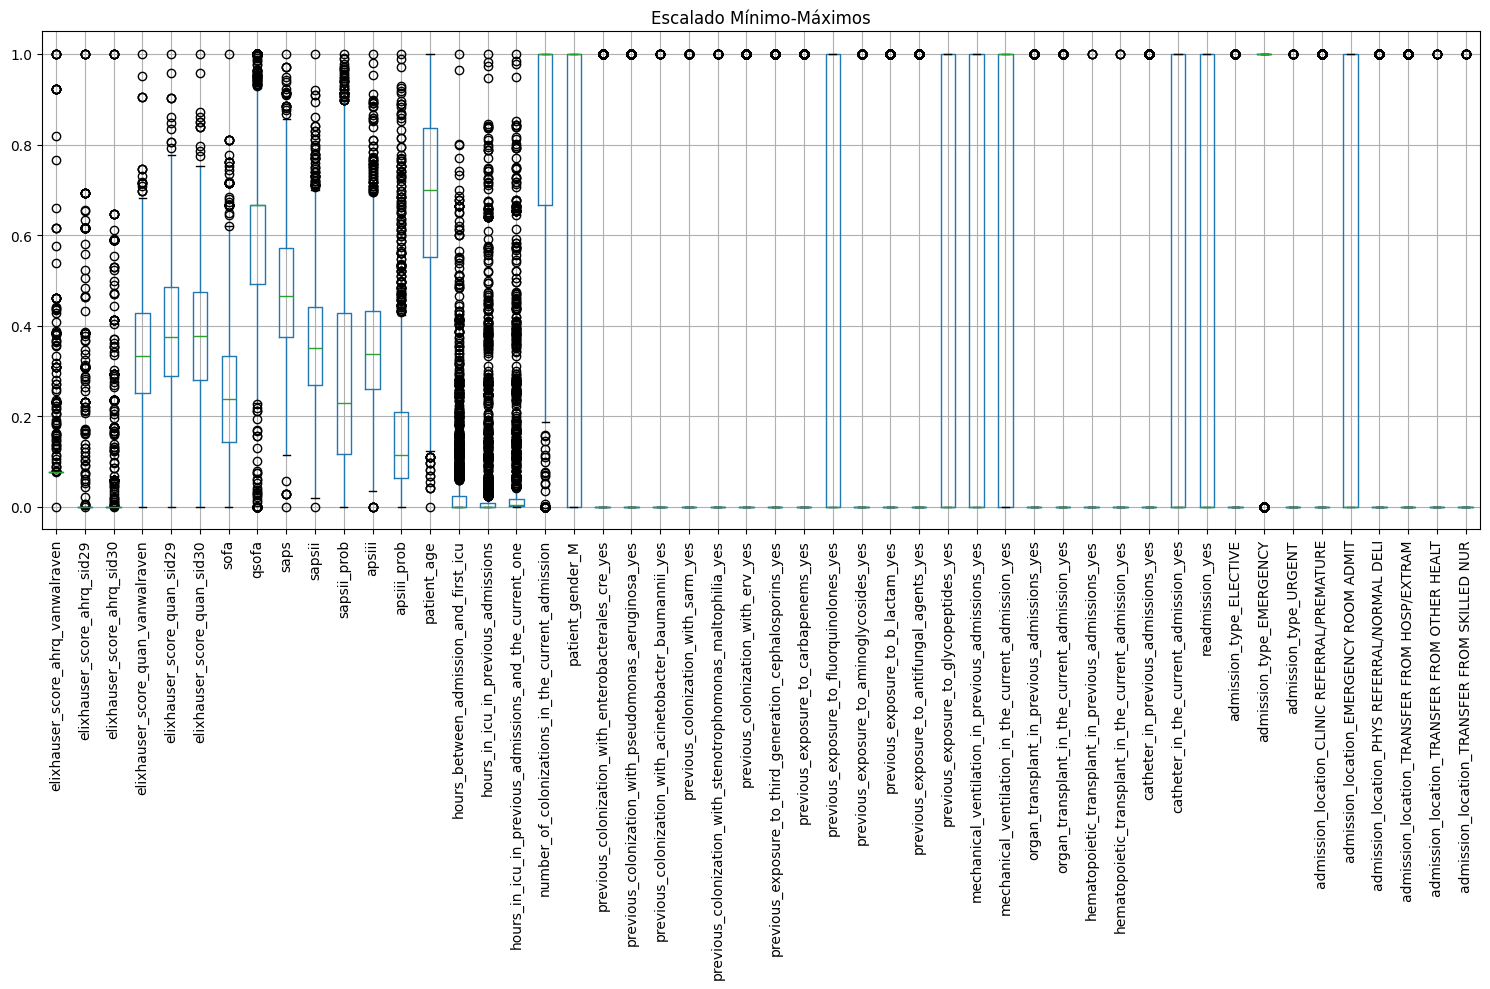

In [29]:
X_train.hist(figsize=(10,8), bins=20, edgecolor='black')

# Hago escalado por minimo-maximo al no haber normalidad en la mayoría de variables
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Convertir a DataFrame
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# Representación después del escalado
plt.figure(figsize=(15,10))
X_train_scaled_df.boxplot(rot=90)
plt.title('Escalado Mínimo-Máximos')
plt.tight_layout()
plt.show()

In [30]:
### Variance Threshold ###
# Para no tener problema con el nombre de las columnas al trabajar con array o dataframe
X_train_columnas = X_train
X_test_columnas = X_test

# Parámetros del selector de características (VarianceThreshold)
selector = VarianceThreshold(threshold=(.8 * (1- .8))) # aprox 0.16, útil para casos de variables desbalanceadas
# con este umbral se eliminarán las variables binarias que sean 1 o 0 en más del 80% de los casos

# Ajusto y transformo sobre X_train y solo transformo sobre X_test
X_train = selector.fit_transform(X_train)
X_test = selector.transform(X_test)

# Convierto los arrays en DataFrame
X_train = pd.DataFrame(X_train, columns=X_train_columnas.columns[selector.get_support()])
X_test = pd.DataFrame(X_test, columns=X_test_columnas.columns[selector.get_support()])

# Número de características y qué características
print(X_train.shape[1])
print(X_train.columns)

28
Index(['elixhauser_score_ahrq_vanwalraven', 'elixhauser_score_ahrq_sid29', 'elixhauser_score_ahrq_sid30', 'elixhauser_score_quan_vanwalraven', 'elixhauser_score_quan_sid29', 'elixhauser_score_quan_sid30', 'sofa', 'qsofa', 'saps', 'sapsii', 'apsiii', 'patient_age', 'hours_between_admission_and_first_icu', 'hours_in_icu_in_previous_admissions', 'hours_in_icu_in_previous_admissions_and_the_current_one', 'number_of_colonizations_in_the_current_admission', 'patient_gender_M', 'previous_exposure_to_fluorquinolones_yes', 'previous_exposure_to_b_lactam_yes', 'previous_exposure_to_antifungal_agents_yes', 'previous_exposure_to_glycopeptides_yes', 'mechanical_ventilation_in_previous_admissions_yes', 'mechanical_ventilation_in_the_current_admission_yes', 'catheter_in_previous_admissions_yes', 'catheter_in_the_current_admission_yes', 'readmission_yes', 'admission_location_CLINIC REFERRAL/PREMATURE', 'admission_location_EMERGENCY ROOM ADMIT'], dtype='object')


6. Modelos de Clustering

1. K-Means

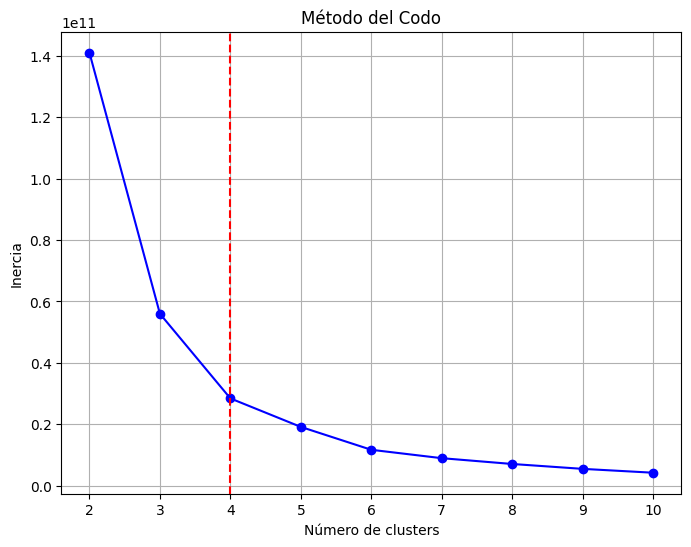

In [31]:
# Al no saber el número de cluster que se deben formar, hay que obtenerlos por el método del Codo
# En realidad utilizo el método del codo como una primera estimación de los clusters a formar
# Método del codo
min_k, max_k = 2, 10
cluster_range = range(min_k, max_k + 1)
inercia = []
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=789, copy_x=True)
    kmeans.fit(X_train) # fit(X) ajusta el modelo a los datos pero no devuelve etiquetas
    inercia.append(kmeans.inertia_)

kl = KneeLocator(list(cluster_range), inercia, curve='convex', direction='decreasing')
elbow_k = kl.knee

# Grafico
plt.figure(figsize=(8,6))
plt.plot(cluster_range, inercia, marker='o', color='blue')
plt.title('Método del Codo')
plt.xlabel('Número de clusters')
plt.ylabel('Inercia')
plt.axvline(x=elbow_k, color='red', linestyle='--', label=f'Codo en k={elbow_k}')
plt.grid(True)
plt.show()



Los 3 clusters con los valores más altos del coeficiente de Silueta:
2 clusters, Coeficiente de Silueta: 0.902
3 clusters, Coeficiente de Silueta: 0.889
6 clusters, Coeficiente de Silueta: 0.878


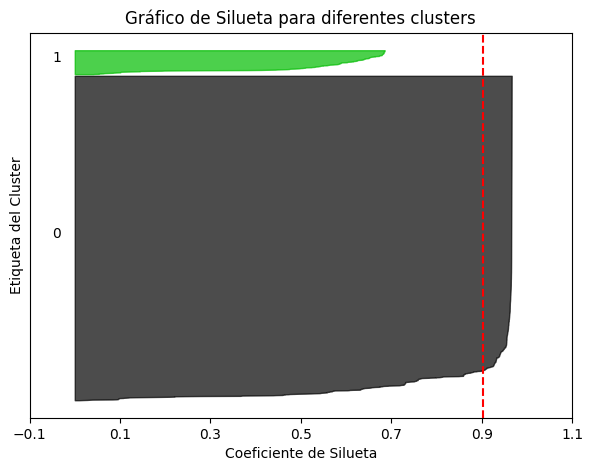

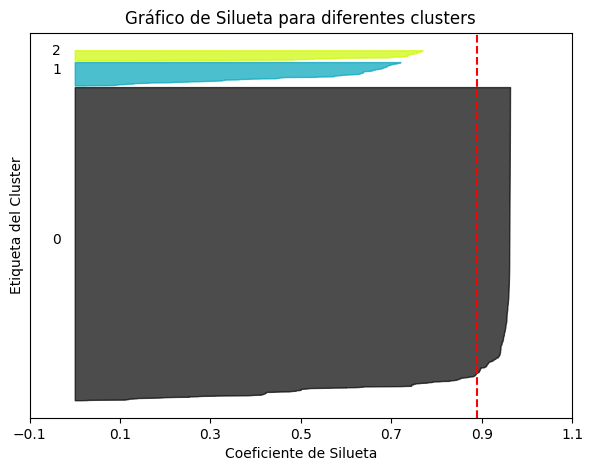

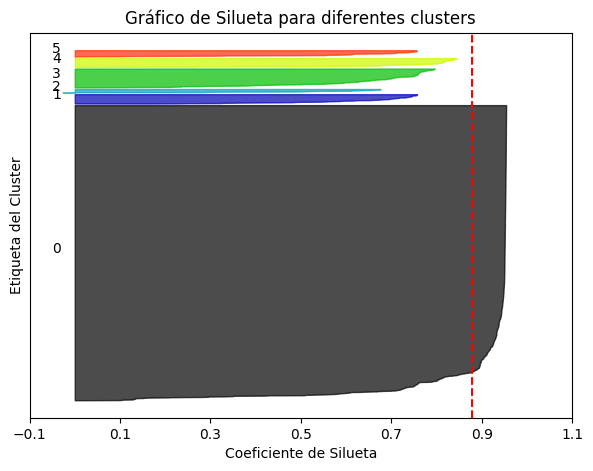

In [32]:
# Después de hacer el método del códo ya sé entre que valores puede estar k optimizado
clusters = range(2, 7)
silueta_scores = {}

# Primero calculamos el índice de Silueta para todos los n_clusters en el rango
for n_clusters in clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=789, copy_x=True)
    cluster_labels = kmeans.fit_predict(X_train) # fit_predict(X) ajusta el modelo a los datos y SI que devuelve las etiquetas

    # Índice de Silueta
    silueta = silhouette_score(X_train, cluster_labels, random_state=789) # silhouette_score es el índice de Silueta global
    silueta_scores[n_clusters] = silueta

# Ordenar los resultados de Silueta en orden descendente y mostrar los 3 mejores
top_silueta = sorted(silueta_scores.items(), key=lambda x: x[1], reverse=True)[:3] #x[0]=n_cluster; x[1]=silueta

# Mostrar los 3 mejores clusters
print("\nLos 3 clusters con los valores más altos del coeficiente de Silueta:")
for n_clusters, score in top_silueta:
    print(f'{n_clusters} clusters, Coeficiente de Silueta: {score:.3f}')

# Almaceno los 3 mejores clusters para hacer una representación solo de estos
top_n_clusters = []
for item in top_silueta:
    top_n_clusters.append(item[0])

# Ahora, generamos solo los gráficos para los 3 mejores clusters
for n_clusters in top_n_clusters:
    # Crear un solo gráfico
    fig, ax1 = plt.subplots(figsize=(7, 5))  # Solo un gráfico

    # Aplicamos KMeans sobre X_train
    kmeans = KMeans(n_clusters=n_clusters, random_state=789, copy_x=True)
    cluster_labels = kmeans.fit_predict(X_train)

    # Índice de Silueta
    silueta = silhouette_score(X_train, cluster_labels, random_state=789)
    silueta_values = silhouette_samples(X_train, cluster_labels) # indice de silueta de un cluster

    # Gráfico de Silueta
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = silueta_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort() # ordeno de menor a mayor

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # Espaciado entre clusters

    ax1.set_title("Gráfico de Silueta para diferentes clusters")
    ax1.set_xlabel("Coeficiente de Silueta")
    ax1.set_ylabel("Etiqueta del Cluster")
    ax1.axvline(x=silueta, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks(np.arange(-0.1, 1.1, 0.2))

    plt.show() 

In [33]:
# 1. Clustering con el mejor número de clusters
best_n_clusters = top_n_clusters[0]
kmeans_final = KMeans(n_clusters=best_n_clusters, random_state=789)
labels_kmeans = kmeans_final.fit_predict(X_train) # Etiquetas de los clusters
centroids_kmeans = kmeans_final.cluster_centers_  # Coordenadas de los centroides

# Calcular Adjusted Rand Index
ari = adjusted_rand_score(y_train, labels_kmeans)
print(f"Adjusted Rand Index para Keans con k={best_n_clusters}: {ari:.4f}")

# 2. Renombrar las clases reales (0 = no hay superb, 1 = Sí hya superb)
y_train_named = y_train.map({0: 'No hay superbacteria', 1: 'Sí hay superbacteria'})

# 3. Crear DataFrame para el Sankey
df_sankey = pd.DataFrame({
    'Cluster': 'Cluster ' + pd.Series(labels_kmeans).astype(str),
    'Clase Real': y_train_named.reset_index(drop=True)
})

# 4. Agrupar combinaciones
links = df_sankey.groupby(['Cluster', 'Clase Real']).size().reset_index(name='count')

# 5. Crear nodos únicos
labels = pd.unique(links[['Cluster', 'Clase Real']].values.ravel())
label_map = {label: i for i, label in enumerate(labels)}

# 6. Mapear texto a índices
source = links['Cluster'].map(label_map)
target = links['Clase Real'].map(label_map)
value = links['count']

# 7. Crear el diagrama Sankey
fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels
    ),
    link=dict(
        source=source,
        target=target,
        value=value
    )
))

fig.update_layout(title_text="Diagrama Sankey: Relación entre Clusters y Clases Reales", font_size=12)
fig.show()


Adjusted Rand Index para Keans con k=2: 0.0009


2. Bisecting K-Means

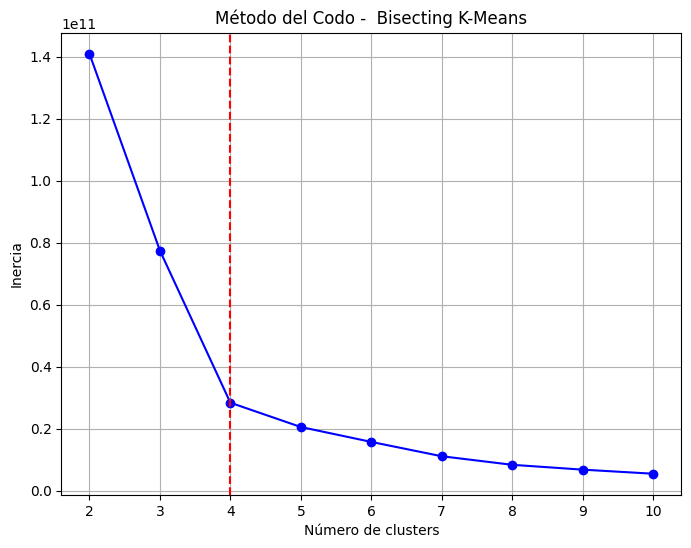

In [34]:
# Convierto el dataframe en array para luego poder visualizarlo
X_array_train = np.array(X_train)

min_k, max_k = 2, 10
cluster_range = range(min_k, max_k + 1)
inercia = []
for k in cluster_range:
    # Ajustar el modelo Bisecting K-Means
    bis_kmeans = BisectingKMeans(n_clusters=k,init='k-means++', random_state=789, copy_x=True, bisecting_strategy='biggest_inertia')
    bis_kmeans.fit(X_array_train) 

    # Guardar la inercia para el valor de k
    inercia.append(bis_kmeans.inertia_)

kl = KneeLocator(list(cluster_range), inercia, curve='convex', direction='decreasing')
elbow_k = kl.knee

# Grafico
plt.figure(figsize=(8,6))
plt.plot(cluster_range, inercia, marker='o', color='blue')
plt.title('Método del Codo -  Bisecting K-Means')
plt.xlabel('Número de clusters')
plt.ylabel('Inercia')
plt.axvline(x=elbow_k, color='red', linestyle='--', label=f'Codo en k={elbow_k}')
plt.grid(True)
plt.show()


Los 3 clusters con los valores más altos del coeficiente de Silueta:
2 clusters, Coeficiente de Silueta: 0.902
3 clusters, Coeficiente de Silueta: 0.880
4 clusters, Coeficiente de Silueta: 0.877


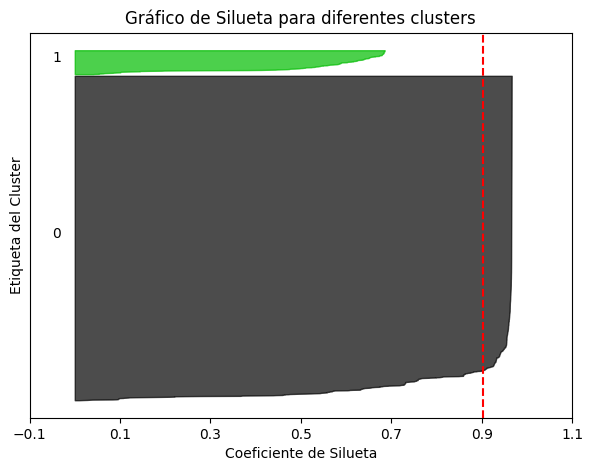

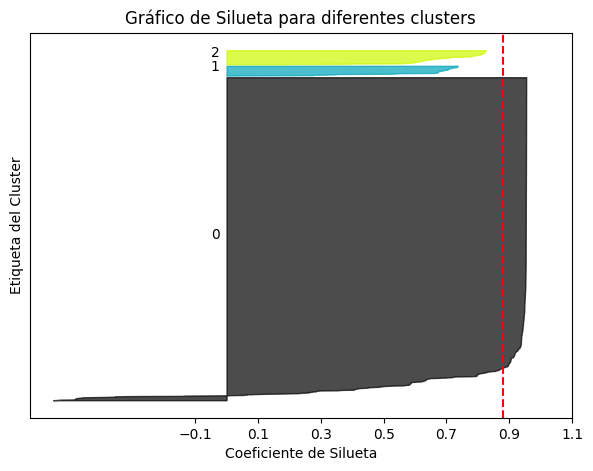

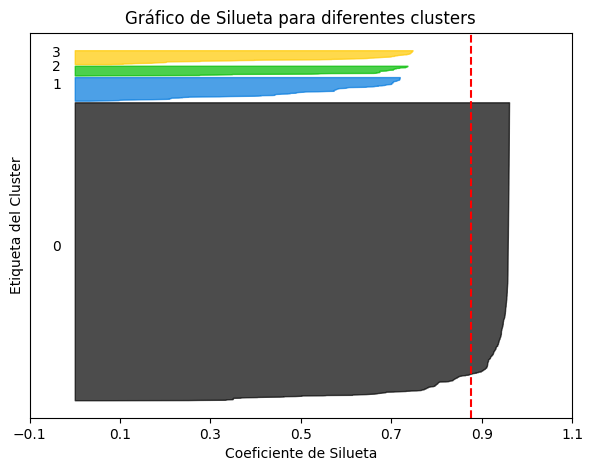

In [35]:
# Método de la Silueta
clusters = range(2, 10)

# Diccionario para almacenar los coeficientes de silueta
silueta_scores = {}

# Calcular el índice de Silueta para cada número de clusters
for n_clusters in clusters:
    bis_kmeans = BisectingKMeans(n_clusters=n_clusters,init='k-means++', random_state=789, copy_x=True, bisecting_strategy='biggest_inertia')
    labels_biskmeans = bis_kmeans.fit_predict(X_array_train)

    # Índice de Silueta
    silueta = silhouette_score(X_array_train, labels_biskmeans)
    silueta_scores[n_clusters] = silueta

# Ordenar los resultados de Silueta en orden descendente y mostrar los 3 mejores
top_silueta = sorted(silueta_scores.items(), key=lambda x: x[1], reverse=True)[:3]

# Mostrar los 3 mejores clusters
print("\nLos 3 clusters con los valores más altos del coeficiente de Silueta:")
for n_clusters, score in top_silueta:
    print(f'{n_clusters} clusters, Coeficiente de Silueta: {score:.3f}')

# Extraer solo los valores de n_clusters
top_n_clusters = []
for item in top_silueta:
    top_n_clusters.append(item[0])
    
# Ahora, generamos solo los gráficos para los 3 mejores clusters
for n_clusters in top_n_clusters:
    # Crear un solo gráfico
    fig, ax1 = plt.subplots(figsize=(7, 5))  # Solo un gráfico

    # Bisecting K-Means sobre variables_array_onehot_train
    bis_kmeans = BisectingKMeans(n_clusters=n_clusters,init='k-means++', random_state=789, copy_x=True, bisecting_strategy='biggest_inertia')
    labels_biskmeans = bis_kmeans.fit_predict(X_array_train)

    # Índice de Silueta
    silueta = silhouette_score(X_array_train, labels_biskmeans, random_state=789)
    silueta_values = silhouette_samples(X_array_train, labels_biskmeans)

    # Gráfico de Silueta
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = silueta_values[labels_biskmeans == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # Espaciado entre clusters

    ax1.set_title("Gráfico de Silueta para diferentes clusters")
    ax1.set_xlabel("Coeficiente de Silueta")
    ax1.set_ylabel("Etiqueta del Cluster")
    ax1.axvline(x=silueta, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks(np.arange(-0.1, 1.1, 0.2))
    plt.show() 

In [36]:
# 1. Clustering con el mejor número de clusters
best_n_clusters = top_n_clusters[0]
bis_kmeans = BisectingKMeans(n_clusters=best_n_clusters,
                             init='k-means++', 
                             random_state=789, 
                             copy_x=True, 
                             bisecting_strategy='biggest_inertia')
labels_biskmeans= bis_kmeans.fit_predict(X_array_train)
centroids_biskmeans = bis_kmeans.cluster_centers_

# Calcular Adjusted Rand Index
ari = adjusted_rand_score(y_train, labels_biskmeans)
print(f"Adjusted Rand Index para Bisecting Kmeans con k={best_n_clusters}: {ari:.4f}")

# 2. Renombrar las clases reales (0 = no hay superb, 1 = Sí hya superb)
y_train_named = y_train.map({0: 'No hay superbacteria', 1: 'Sí hay superbacteria'})

# 3. Crear DataFrame para el Sankey
df_sankey = pd.DataFrame({
    'Cluster': 'Cluster ' + pd.Series(labels_biskmeans).astype(str),
    'Clase Real': y_train_named.reset_index(drop=True)
})

# 4. Agrupar combinaciones
links = df_sankey.groupby(['Cluster', 'Clase Real']).size().reset_index(name='count')

# 5. Crear nodos únicos
labels = pd.unique(links[['Cluster', 'Clase Real']].values.ravel())
label_map = {label: i for i, label in enumerate(labels)}

# 6. Mapear texto a índices
source = links['Cluster'].map(label_map)
target = links['Clase Real'].map(label_map)
value = links['count']

# 7. Crear el diagrama Sankey
fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels
    ),
    link=dict(
        source=source,
        target=target,
        value=value
    )
))

fig.update_layout(title_text="Diagrama Sankey: Relación entre Clusters y Clases Reales", font_size=12)
fig.show()


Adjusted Rand Index para Bisecting Kmeans con k=2: 0.0009


3. DBSCAN

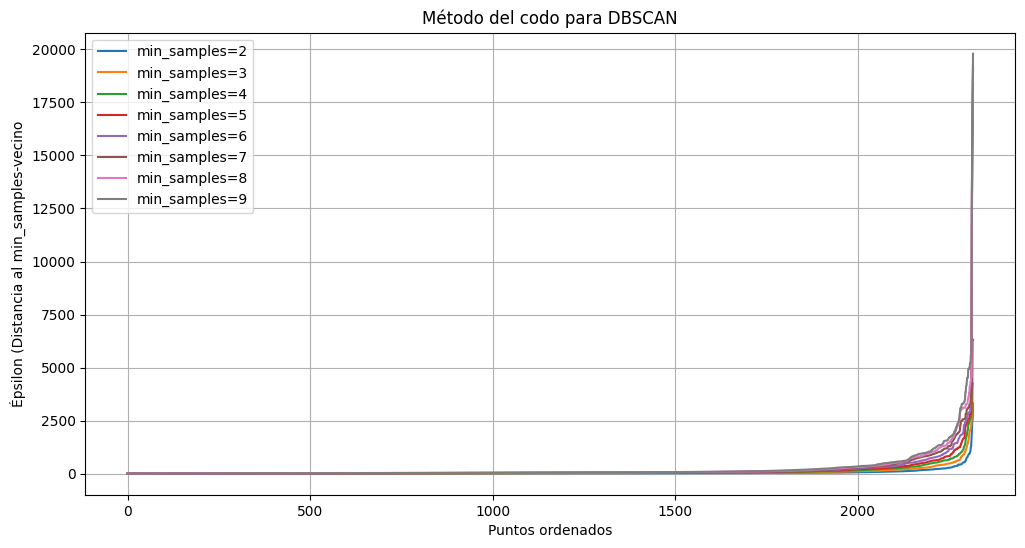

Con un mínimo de puntos de 2, el valor óptimo de épsilon es 442.948
Con un mínimo de puntos de 3, el valor óptimo de épsilon es 912.754
Con un mínimo de puntos de 4, el valor óptimo de épsilon es 6317.139
Con un mínimo de puntos de 5, el valor óptimo de épsilon es 1244.463
Con un mínimo de puntos de 6, el valor óptimo de épsilon es 2899.623
Con un mínimo de puntos de 7, el valor óptimo de épsilon es 3124.654
Con un mínimo de puntos de 8, el valor óptimo de épsilon es 3110.244
Con un mínimo de puntos de 9, el valor óptimo de épsilon es 4940.700


In [37]:
# Definir valores para min_samples
min_samples_values = range(2,10)
eps_optimos = {}

# Creación de la figura
plt.figure(figsize=(12,6))

# Pruebo distintos valores de min_samples:
for min_samples in min_samples_values:
    # Ajusto el modelo de KNN
    vecinos = NearestNeighbors(n_neighbors=min_samples).fit(X_train)
    distancias, indices = vecinos.kneighbors(X_train) # Calculo las distancias a los vecinos más cercanos
    # distancias: matriz nxm donde n=numero de puntos y m=min_samples. Me da las distancias de cada punto n a los m vecinos
    # indices: matriz nxm donde  n=numero de puntos y m=min_samples. Me da los índices de cada m vecino a cada n punto.
    # Obtengo la distancia del k-ésimo vecino y ordeno
    distancias_min_samples = distancias[:,-1] # me quedo con la última columna de la matriz (distancia del k-ésimo vecino)
    distancias_min_samples.sort() # para ordenar las distancias en orden ascendente para detectar cambios luego en el codo

    # Para encontrar el codo (epsilon) automáticamente con la función knee
    indices = range(len(distancias_min_samples)) # El indice es igual al número de puntos en el dataset
    knee = KneeLocator(indices, distancias_min_samples, curve='convex', direction='increasing')

    # Obtener el valor óptimo de eps
    if knee.knee is not None:
        eps_optimos[min_samples] = distancias_min_samples[knee.knee]
    else:
        eps_optimos[min_samples] = None
    
    # Grafico con la curva de distancias
    plt.plot(distancias_min_samples, label=f'min_samples={min_samples}')

# Configuro el gráfico
plt.xlabel('Puntos ordenados')
plt.ylabel('Épsilon (Distancia al min_samples-vecino')
plt.title('Método del codo para DBSCAN')
plt.grid()
plt.legend()
plt.show()

best_params = eps_optimos #{clave = min_value; valor = epsilon}

for min_sample, epsilon_value in best_params.items():
    print(f'Con un mínimo de puntos de {min_sample}, el valor óptimo de épsilon es {epsilon_value:.3f}')

Para eps=442.9481 y min_samples=2, se encontraron 46 cluster (indice de silueta=0.4581) y 32 puntos de ruido
Tamaño de cada cluster: {np.int64(0): np.int64(1958), np.int64(1): np.int64(13), np.int64(2): np.int64(28), np.int64(3): np.int64(11), np.int64(4): np.int64(27), np.int64(5): np.int64(2), np.int64(6): np.int64(6), np.int64(7): np.int64(2), np.int64(8): np.int64(12), np.int64(9): np.int64(22), np.int64(10): np.int64(12), np.int64(11): np.int64(46), np.int64(12): np.int64(6), np.int64(13): np.int64(23), np.int64(14): np.int64(5), np.int64(15): np.int64(7), np.int64(16): np.int64(3), np.int64(17): np.int64(3), np.int64(18): np.int64(2), np.int64(19): np.int64(4), np.int64(20): np.int64(6), np.int64(21): np.int64(5), np.int64(22): np.int64(4), np.int64(23): np.int64(5), np.int64(24): np.int64(16), np.int64(25): np.int64(4), np.int64(26): np.int64(2), np.int64(27): np.int64(2), np.int64(28): np.int64(3), np.int64(29): np.int64(3), np.int64(30): np.int64(3), np.int64(31): np.int64(2),

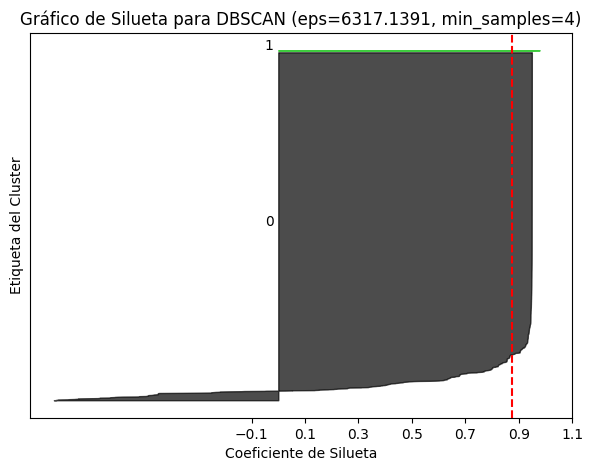

Para eps=6317.139, min_samples=4, el tamaño del cluster es: {np.int64(0): np.int64(2312), np.int64(1): np.int64(4)}


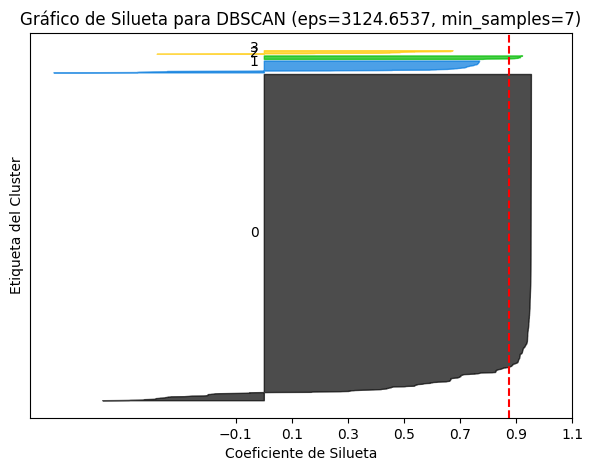

Para eps=3124.654, min_samples=7, el tamaño del cluster es: {np.int64(0): np.int64(2183), np.int64(1): np.int64(80), np.int64(2): np.int64(24), np.int64(3): np.int64(25)}


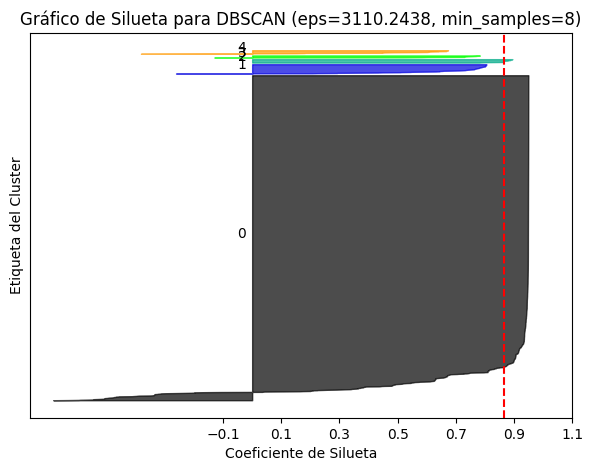

Para eps=3110.244, min_samples=8, el tamaño del cluster es: {np.int64(0): np.int64(2183), np.int64(1): np.int64(64), np.int64(2): np.int64(24), np.int64(3): np.int64(15), np.int64(4): np.int64(25)}


In [38]:
# Evaluamos DBSCAN con las combinaciones óptimas de min_samples y eps
top_n_clusters = []
for min_samples, eps in best_params.items():
    dbscan = DBSCAN(eps=eps, 
                    min_samples=min_samples)
    labels_dbscan = dbscan.fit_predict(X_train)  # Para obtener las etiquetas

    # Contar los clusters excluyendo el ruido (-1)
    unique_labels = set(labels_dbscan)
    unique_labels.discard(-1)  # Remover el ruido
    n_clusters = len(unique_labels)
    
    # Contar los puntos de ruido
    n_noise = sum(labels_dbscan == -1)
    
    # Contar las muestras en cada cluster
    cluster_counts = {label: sum(labels_dbscan == label) for label in unique_labels}
    
    # Calcular el índice de silueta solo si hay más de un cluster
    if n_clusters > 1:
        silueta = silhouette_score(X_train, labels_dbscan)
        silueta_values = silhouette_samples(X_train, labels_dbscan)
        top_n_clusters.append((n_clusters, min_samples, eps, silueta, n_noise, cluster_counts))
        print(f'Para eps={eps:.4f} y min_samples={min_samples}, se encontraron {n_clusters} cluster (indice de silueta={silueta:.4f}) y {n_noise} puntos de ruido')
        print(f'Tamaño de cada cluster: {cluster_counts}')

# Ordenamos los clusters por mejor índice de silueta y tomamos los 3 mejores
top_n_clusters.sort(key=lambda x: x[3], reverse=True) # x[3] = silueta, entonces se ordena por el índice de silueta
top_n_clusters = top_n_clusters[:3]

# Generamos los gráficos de silueta
for n_clusters, min_samples, eps, silueta, n_noise, cluster_counts in top_n_clusters:
    fig, ax1 = plt.subplots(figsize=(7, 5))
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels_dbscan = dbscan.fit_predict(X_train)
    silueta_values = silhouette_samples(X_train, labels_dbscan)
    
    y_lower = 10
    for i, label in enumerate(set(labels_dbscan)):
        if label == -1:
            continue  # Omitimos el ruido
        ith_cluster_silhouette_values = silueta_values[labels_dbscan == label]
        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(label))
        y_lower = y_upper + 10
    
    ax1.set_title(f"Gráfico de Silueta para DBSCAN (eps={eps:.4f}, min_samples={min_samples})")
    ax1.set_xlabel("Coeficiente de Silueta")
    ax1.set_ylabel("Etiqueta del Cluster")
    ax1.axvline(x=silueta, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks(np.arange(-0.1, 1.1, 0.2))
    plt.show()
    
    print(f'Para eps={eps:.3f}, min_samples={min_samples}, el tamaño del cluster es: {cluster_counts}')



In [39]:
# Tomo los mejores parámetros (el primero de top_n_clusters)
best_n_clusters_dbscan = top_n_clusters[0]
n_clusters, min_samples, eps, silueta, n_noise, cluster_counts = best_n_clusters_dbscan

# DBSCAN utilizando los best_n_clusters_dbscan parámetros
dbscan = DBSCAN (eps=eps, min_samples=min_samples)
labels_dbscan = dbscan.fit_predict(X_train)

# Cálculo del índice Rand ajustado (con ruido)
ari_con_ruido = adjusted_rand_score(y_train, labels_dbscan)
print(f"Adjusted Rand Index (con ruido): {ari_con_ruido:.4f}")

# Cálculo del índice Rand ajustado (sin ruido)
mask = labels_dbscan != -1
ari_sin_ruido = adjusted_rand_score(y_train[mask], labels_dbscan[mask])
print(f"Adjusted Rand Index (sin ruido): {ari_sin_ruido:.4f}")


# Renombro las clases reales (0 = no hay superb: 1= si hay superb)
y_train_named = y_train.map({0: "No hay superbacteria", 1: "Sí hay superbacteria"})

# Creo el DF para hacer Sankey
labels_dbscan_named = ['Ruido' if label == -1 else f'Cluster {label}' for label in labels_dbscan]
df_sankey = pd.DataFrame({
    'Cluster': labels_dbscan_named,
    'Clase Real': y_train_named.reset_index(drop=True)
})

# Agrupación de combinaciones
links = df_sankey.groupby(['Cluster', 'Clase Real']).size().reset_index(name='count')

# Creo nodos únicos
labels = pd.unique(links[['Cluster', 'Clase Real']].values.ravel())
label_map = {label: i for i, label in enumerate(labels)}

# Mapeo texto a índices
source = links['Cluster'].map(label_map)
target = links['Clase Real'].map(label_map)
value = links['count']

# Creo el diagrama de Sankey
fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict (color="black", width=0.5),
        label = labels
    ),
    link=dict(
        source = source,
        target = target,
        value = value
    )
))

fig.update_layout(title_text=f"Diagrama de Sankey DBSCAN (eps={eps:.3f}, min_samples={min_samples})", font_size =12)
fig.show()

Adjusted Rand Index (con ruido): 0.0000
Adjusted Rand Index (sin ruido): 0.0000


4. HDBSCAN

In [40]:
min_cluster_sizes = [5, 10, 15]
min_samples_list = [None, 10, 15]
alphas = [1.0, 1.5, 2.0]

best_params = None
best_score = -1
best_num_clusters = 0

for min_cluster_size in min_cluster_sizes:
    for min_samples in min_samples_list:
        for alpha in alphas:
            clusterer = HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, alpha=alpha).fit(X_train)
            labels = clusterer.labels_
            
            unique_labels = set(labels)
            num_clusters = len(unique_labels - {-1})
            
            if num_clusters > 1:
                score = silhouette_score(X_train, labels)
                print(f"Params: min_cluster_size={min_cluster_size}, min_samples={min_samples}, alpha={alpha}, Silhouette: {score:.4f}, Number of clusters: {num_clusters}")
                
                if score > best_score:
                    best_score = score
                    best_params = (min_cluster_size, min_samples, alpha)
                    best_num_clusters = num_clusters

if best_params:
    print(f"\nMejores parámetros encontrados: min_cluster_size={best_params[0]}, min_samples={best_params[1]}, alpha={best_params[2]} con Silhouette Score: {best_score:.4f}")
    print(f"Número de clusters con los mejores parámetros: {best_num_clusters}")
else:
    print("\nNo se encontraron parámetros con un número de clusters válido.")


Params: min_cluster_size=5, min_samples=None, alpha=1.0, Silhouette: -0.0515, Number of clusters: 76
Params: min_cluster_size=5, min_samples=None, alpha=1.5, Silhouette: 0.0196, Number of clusters: 63
Params: min_cluster_size=5, min_samples=None, alpha=2.0, Silhouette: 0.1672, Number of clusters: 47
Params: min_cluster_size=5, min_samples=10, alpha=1.0, Silhouette: 0.1578, Number of clusters: 33
Params: min_cluster_size=5, min_samples=10, alpha=1.5, Silhouette: 0.2098, Number of clusters: 29
Params: min_cluster_size=5, min_samples=10, alpha=2.0, Silhouette: -0.0891, Number of clusters: 30
Params: min_cluster_size=5, min_samples=15, alpha=1.0, Silhouette: 0.0781, Number of clusters: 26
Params: min_cluster_size=5, min_samples=15, alpha=1.5, Silhouette: 0.1628, Number of clusters: 19
Params: min_cluster_size=5, min_samples=15, alpha=2.0, Silhouette: -0.0940, Number of clusters: 21
Params: min_cluster_size=10, min_samples=None, alpha=1.0, Silhouette: 0.1586, Number of clusters: 31
Params: 

Silhouette Score con método 'eom': 0.2098
Silhouette Score con método 'leaf': -0.4269

Mejor método: 'eom' con Silhouette Score de 0.2098
Número de clusters formados: 29
Puntos clasificados como ruido: 570
Tamaño de cada cluster: {np.int64(0): np.int64(38), np.int64(1): np.int64(11), np.int64(2): np.int64(41), np.int64(3): np.int64(11), np.int64(4): np.int64(16), np.int64(5): np.int64(23), np.int64(6): np.int64(22), np.int64(7): np.int64(8), np.int64(8): np.int64(19), np.int64(9): np.int64(28), np.int64(10): np.int64(18), np.int64(11): np.int64(23), np.int64(12): np.int64(16), np.int64(13): np.int64(40), np.int64(14): np.int64(38), np.int64(15): np.int64(13), np.int64(16): np.int64(36), np.int64(17): np.int64(17), np.int64(18): np.int64(14), np.int64(19): np.int64(19), np.int64(20): np.int64(17), np.int64(21): np.int64(15), np.int64(22): np.int64(30), np.int64(23): np.int64(18), np.int64(24): np.int64(12), np.int64(25): np.int64(9), np.int64(26): np.int64(35), np.int64(27): np.int64(11

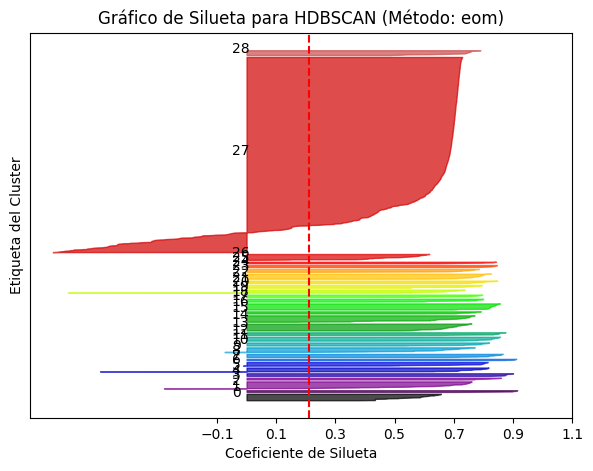

In [41]:
# Los mejores parámetros son:
# min_cluster_size = 5 (por defecto)
# min_samples = None (por defecto, toma el valor de min_cluster_size)
# alpha = 1.0
# Ahora queda por determinar si mejor 'eom' o 'leaf'

# Evaluamos HDBSCAN con 'eom' y 'leaf' para determinar el mejor método
cluster_selection_method = ['eom', 'leaf']
best_method = None
best_silhouette = -1  # Inicializamos con un valor bajo
best_labels = None

for method in cluster_selection_method:
    hdbscan = HDBSCAN(min_cluster_size=best_params[0], min_samples=best_params[1], alpha=best_params[2],
                       cluster_selection_method=method, allow_single_cluster=False, store_centers='centroid')
    hdbscan_labels = hdbscan.fit_predict(X_train)

    unique_labels = set(hdbscan_labels)
    num_clusters = len(unique_labels - {-1})

    if num_clusters > 1:
        silhouette_avg = silhouette_score(X_train, hdbscan_labels)
        print(f"Silhouette Score con método '{method}': {silhouette_avg:.4f}")
        
        if silhouette_avg > best_silhouette:
            best_silhouette = silhouette_avg
            best_method = method
            best_labels = hdbscan_labels
    else:
        print(f"Silhouette Score no calculado para '{method}' (solo hay un cluster).")

if best_method:
    num_clusters = len(set(best_labels)) - (1 if -1 in best_labels else 0)  # Excluir el cluster de ruido (-1)
    num_noise_points = sum(best_labels == -1)  # Contar los puntos de ruido
    
    # Contar las muestras en cada cluster
    cluster_counts = {label: sum(best_labels == label) for label in set(best_labels) if label != -1}
    
    print(f"\nMejor método: '{best_method}' con Silhouette Score de {best_silhouette:.4f}")
    print(f"Número de clusters formados: {num_clusters}")
    print(f"Puntos clasificados como ruido: {num_noise_points}")
    print(f"Tamaño de cada cluster: {cluster_counts}")

    # Generamos el gráfico de silueta
    fig, ax1 = plt.subplots(figsize=(7, 5))
    silueta_values = silhouette_samples(X_train, best_labels)
    
    y_lower = 10
    for i, label in enumerate(set(best_labels)):
        if label == -1:
            continue  # Omitimos el ruido
        ith_cluster_silhouette_values = silueta_values[best_labels == label]
        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = cm.nipy_spectral(float(i) / num_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(label))
        y_lower = y_upper + 10
    
    ax1.set_title(f"Gráfico de Silueta para HDBSCAN (Método: {best_method})")
    ax1.set_xlabel("Coeficiente de Silueta")
    ax1.set_ylabel("Etiqueta del Cluster")
    ax1.axvline(x=best_silhouette, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks(np.arange(-0.1, 1.1, 0.2))
    plt.show()

In [42]:
# Renombrar las clases reales
y_train_named = y_train.map({0: 'No hay superbacteria', 1: 'Sí hay superbacteria'})

# Cálculo del ARI (con ruido)
ari_con_ruido = adjusted_rand_score(y_train, best_labels)
print(f"Adjusted Rand Index (con ruido): {ari_con_ruido:.4f}")

# Cálculo del ARI (sin ruido)
mask = best_labels != -1
ari_sin_ruido = adjusted_rand_score(y_train[mask], best_labels[mask])
print(f"Adjusted Rand Index (sin ruido): {ari_sin_ruido:.4f}")

# Crear DataFrame para el Sankey
df_sankey = pd.DataFrame({
    'Cluster': ['Cluster ' + str(lbl) if lbl != -1 else 'Ruido' for lbl in best_labels],
    'Clase Real': y_train_named.reset_index(drop=True)
})

# Agrupar combinaciones
links = df_sankey.groupby(['Cluster', 'Clase Real']).size().reset_index(name='count')

# Crear nodos únicos
labels = pd.unique(links[['Cluster', 'Clase Real']].values.ravel())
label_map = {label: i for i, label in enumerate(labels)}

# Mapear texto a índices
source = links['Cluster'].map(label_map)
target = links['Clase Real'].map(label_map)
value = links['count']

# Crear el diagrama Sankey
fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels
    ),
    link=dict(
        source=source,
        target=target,
        value=value
    )
))

fig.update_layout(title_text="Diagrama Sankey: Clusters de HDBSCAN vs Clases Reales", font_size=12)
fig.show()


Adjusted Rand Index (con ruido): 0.0589
Adjusted Rand Index (sin ruido): 0.1030


5. GMM

Para un total de 2 clusters (componentes), con covarianza de tipo tied, el índice de Silueta es 0.9042
Tamaño de cada cluster: {np.int64(0): np.int64(2181), np.int64(1): np.int64(135)}


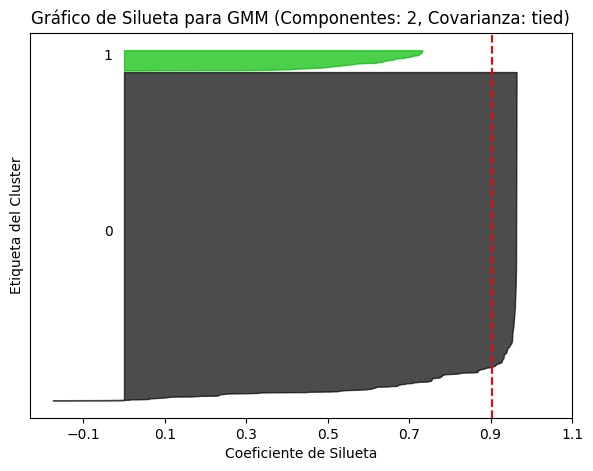

In [43]:
best_gmm = None
best_silhouette = -1
best_params = None
best_labels = None

# Rango de componentes y covarianzas a probar
n_components_range = range(2, 10)
covariance_types = ["spherical", "tied", "diag", "full"]

for n_components in n_components_range:
    for covariance_type in covariance_types:
        gmm = GaussianMixture(n_components=n_components, covariance_type=covariance_type, random_state=789)
        gmm_labels = gmm.fit_predict(X_train)
        
        silhouette_avg = silhouette_score(X_train, gmm_labels)
        
        if silhouette_avg > best_silhouette:
            best_silhouette = silhouette_avg
            best_gmm = gmm
            best_params = {"n_components": n_components, "covariance_type": covariance_type}
            best_labels = gmm_labels

optimal_components = best_params["n_components"]
best_covariance_type = best_params["covariance_type"]
print(f'Para un total de {optimal_components} clusters (componentes), con covarianza de tipo {best_covariance_type}, el índice de Silueta es {best_silhouette:.4f}')

# Generamos el gráfico de silueta
fig, ax1 = plt.subplots(figsize=(7, 5))
silueta_values = silhouette_samples(X_train, best_labels)

# Contar muestras en cada cluster
cluster_counts = {label: sum(best_labels == label) for label in set(best_labels)}
print(f"Tamaño de cada cluster: {cluster_counts}")

y_lower = 10
for i, label in enumerate(set(best_labels)):
    ith_cluster_silhouette_values = silueta_values[best_labels == label]
    ith_cluster_silhouette_values.sort()
    
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = cm.nipy_spectral(float(i) / optimal_components)
    ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(label))
    y_lower = y_upper + 10

ax1.set_title(f"Gráfico de Silueta para GMM (Componentes: {optimal_components}, Covarianza: {best_covariance_type})")
ax1.set_xlabel("Coeficiente de Silueta")
ax1.set_ylabel("Etiqueta del Cluster")
ax1.axvline(x=best_silhouette, color="red", linestyle="--")
ax1.set_yticks([])
ax1.set_xticks(np.arange(-0.1, 1.1, 0.2))
plt.show()

In [45]:
# Renombrar las clases reales
y_train_named = y_train.map({0: 'Sin infección por K. BLEE', 1: 'Con infección por K. BLEE'})

# Cálculo del ARI
ari_gmm = adjusted_rand_score(y_train, best_labels)
print(f"Adjusted Rand Index (con ruido): {ari_gmm:.4f}")

# Crear DataFrame para el Sankey
df_sankey = pd.DataFrame({
    'Cluster': ['Cluster ' + str(lbl) for lbl in best_labels],
    'Clase Real': y_train_named.reset_index(drop=True)
})

# Agrupar combinaciones
links = df_sankey.groupby(['Cluster', 'Clase Real']).size().reset_index(name='count')

# Crear nodos únicos
labels = pd.unique(links[['Cluster', 'Clase Real']].values.ravel())
label_map = {label: i for i, label in enumerate(labels)}

# Mapear texto a índices
source = links['Cluster'].map(label_map)
target = links['Clase Real'].map(label_map)
value = links['count']

# Crear el diagrama Sankey
fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels
    ),
    link=dict(
        source=source,
        target=target,
        value=value
    )
))

fig.update_layout(title_text="Diagrama Sankey: Clusters de GMM vs Clases Reales", 
                  font_size=12,
                  width=600,
                  height=400)
fig.show()

Adjusted Rand Index (con ruido): 0.0003
